# 6. Model Inference

In [1]:
from __init__ import set_path

set_path()

In [2]:
import pandas as pd

from tfcaidm import Jobs
from tfcaidm import Model
from tfcaidm import Dataset

When on the caidm servers, we can also specify a gpu to allocate using the `gpus` method from jarvis.

## Setup

1. Get hyperparameters
2. Load a dataset
3. Create a model

**Autoselect GPU (use only on caidm cluster)**

In [3]:
from jarvis.utils.general import gpus
gpus.autoselect()

[ 2021-11-19 13:48:56 ] WARNING 1 GPU device(s) requested but only 0 available 


In [4]:
YAML_PATH = "/home/brandon/tfcaidm-pkg/configs/ymls/xr_pna/pipeline.yml"

### Hyperparameters

In [5]:
# --- Get hyperparameters
runs = Jobs(path=YAML_PATH)

# --- Hyperparameters for N runs
all_hyperparams = runs.get_params()

# ---- Hyperparameters for run #1
hyperparams = all_hyperparams[0]

In [6]:
hyperparams

{'env/path/root': 'exp',
 'env/path/name': 'xr_pna',
 'env/path/client': '/home/brandon/tfcaidm-pkg/configs/ymls/xr_pna/client.yml',
 'model/model': 'unet',
 'model/conv_type': 'conv',
 'model/pool_type': 'conv',
 'model/eblock': 'conv',
 'model/elayer': 1,
 'model/dblock': 'conv',
 'model/depth': 4,
 'model/width': 32,
 'model/width_scaling': 1,
 'model/kernel_size': [3, 3, 3],
 'model/strides': [2, 2, 2],
 'model/bneck': 2,
 'model/branches': 4,
 'model/atrous_rate': 6,
 'model/order': 'rnc',
 'model/norm': 'bnorm',
 'model/activ': 'leaky',
 'model/attn_msk': 'softmax',
 'train/xs/dat': None,
 'train/ys/pna/mask_id': 'msk',
 'train/ys/pna/remove_bg': True,
 'train/ys/pna/mask_weight': 1,
 'train/ys/pna/output_weight': 5,
 'train/ys/pna/head': 'decoder_classifier',
 'train/ys/pna/n_classes': 2,
 'train/ys/pna/loss': 'sce',
 'train/ys/pna/metric': 'dice',
 'train/trainer/seed': 0,
 'train/trainer/n_folds': 1,
 'train/trainer/batch_size': 8,
 'train/trainer/iters': 3000,
 'train/trainer

### Dataset

In [7]:
client = Dataset(hyperparams).get_client(fold=0)

### Model

Model definition:

```json
{
    "model/model": "unet",
    "model/conv_type": "default",
    "model/pool_type": "default",
    "model/iblock": "default",
    "model/dblock": "default",
    "model/depth": 3,
    "model/width": 8,
    "model/width_scaling": 1,
    "model/bneck": 2,
    "model/layers": 5,
    "model/branches": 4,
    "model/order": "rbc",
    "model/norm": "bnorm",
    "model/activ": "leaky",
    "model/attn_msk": "softmax",
}
 ```

In [8]:
from tensorflow.keras import Input

In [9]:
nn = Model(client)
inputs = client.get_inputs(Input)

In [10]:
model = nn.build()

(None, 1, 512, 512, 32)
(None, 1, 256, 256, 32)
(None, 1, 128, 128, 32)
(None, 1, 64, 64, 32)
(None, 1, 32, 32, 32)
(None, 1, 64, 64, 32)
(None, 1, 128, 128, 32)
(None, 1, 256, 256, 32)
(None, 1, 512, 512, 32)


In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dat (InputLayer)                [(None, 1, 512, 512, 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 1, 512, 512,  64          dat[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 1, 512, 512,  128         conv3d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 1, 512, 512,  0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Inference

### Data

Get some test data by invoking `create_generators` using the jarvis client.

In [12]:
gen_train, gen_valid = client.create_generators(test=True)

In [13]:
xs, ys = next(gen_train)

[ 2021-11-19 13:49:39 ] [>...................] 0.125% : Iterating | 000001      

### Forward pass

Using an untrained, randomly initialized model, run a forward pass.

In [14]:
import numpy as np
from tensorflow.keras import Model as TFModel

In [15]:
yhat = model(xs)

### Visualize

Using the `imshow` function in jarvis we can visualize the model inputs and outputs.

In [16]:
from jarvis.utils.display import imshow

In [17]:
def showall(x, figsize=(2,2)):
    for k in x:
        if x[k].ndim >= 4:
            if x[k].shape[-1] > 1:
                x[k] = np.argmax(x[k], axis=-1)
            imshow(x[k], title=k, figsize=figsize)

#### Ground-truth

##### Inputs

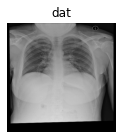

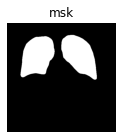

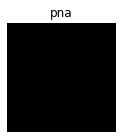

In [19]:
showall(xs) # msk-pna is not actually passed in as an input, it is used for class weights...

##### Outputs

In [20]:
showall(ys)

#### Prediction

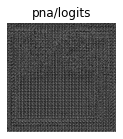

In [21]:
showall(yhat)